# Machine learning for muon energy reconstruction in a high-granularity calorimeter
 

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import h5py
import json
import matplotlib.pyplot as plt
import sparse
from pathlib import Path

In [2]:
from metric import compute_improvement

In [3]:
from plotting import *

## Visualization of a single muon in the calorimeter 

The calorimeter is segmented into 50 layers in $z$ and each layer is further segmented in $x$ and $y$ in $32 \times 32$ cells. This results in $51200$ channels in total. The muon enters the simulated calorimeter in the $z$ direction. The colour palette indicates logarithmic energy deposits of the muon. Black corresponds to zero, red to intermediate, and white to the maximum energy. 

In [4]:
hits, true_energy = load_tree("0.root")

In [5]:
hits_sub, true_energy_sub = restrict_energy(hits, true_energy, e_range = [1500, 1800])

plotting...


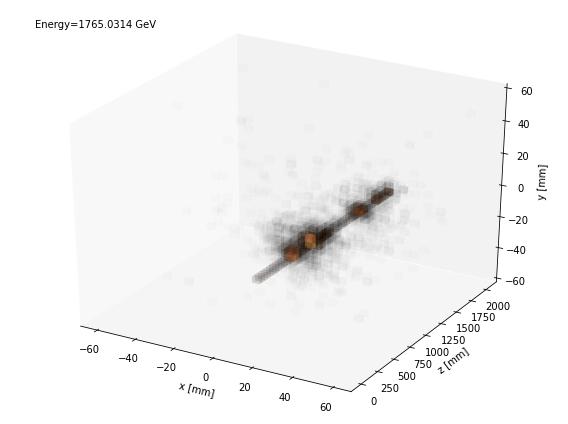

In [6]:
plot_eventdisplay(1, hits_sub, true_energy_sub, usegrid=False, save=False)

## Load high level features

In [7]:
# Make sure to give the correct path to your data storage!
PATH = Path("/jet/home/llayer/muon_reg/data")

In [8]:
def get_hl(file_name:str, path:Path=PATH):
    
    file = h5py.File(path/file_name, "r+")
    cont_feats = json.loads(file['meta_data/cont_feats'][()])
    hl_inputs = file['fold_0/inputs'][()]  # muon x feature numpy array
    targets = file['fold_0/targets'][()]  # muon x 1
    file.close()
    return hl_inputs, targets

In [9]:
X_train, y_train = get_hl('muon_calo_train.hdf5')
X_val, y_val = get_hl('muon_calo_val.hdf5')

## Regression with a Boosted Decision Tree with high level features

In [10]:
# create an xgboost regression model
bdt = xgb.XGBRegressor(objective='reg:squarederror')

In [11]:
bdt.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

[0]	validation_0-rmse:3431.57202	validation_1-rmse:3442.56470
[1]	validation_0-rmse:2651.99585	validation_1-rmse:2664.35498
[2]	validation_0-rmse:2166.15869	validation_1-rmse:2180.58057
[3]	validation_0-rmse:1877.03528	validation_1-rmse:1893.61145
[4]	validation_0-rmse:1713.68054	validation_1-rmse:1732.47278
[5]	validation_0-rmse:1624.74011	validation_1-rmse:1646.39539
[6]	validation_0-rmse:1576.13501	validation_1-rmse:1600.81397
[7]	validation_0-rmse:1548.75574	validation_1-rmse:1576.75818
[8]	validation_0-rmse:1533.11145	validation_1-rmse:1562.65173
[9]	validation_0-rmse:1523.62488	validation_1-rmse:1555.32605
[10]	validation_0-rmse:1517.62805	validation_1-rmse:1551.33826
[11]	validation_0-rmse:1513.12012	validation_1-rmse:1548.86206
[12]	validation_0-rmse:1508.63477	validation_1-rmse:1547.29773
[13]	validation_0-rmse:1504.47559	validation_1-rmse:1545.88635
[14]	validation_0-rmse:1501.32288	validation_1-rmse:1545.74695
[15]	validation_0-rmse:1499.25244	validation_1-rmse:1545.07837
[1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [12]:
y_pred = bdt.predict(X_val) # Predictions

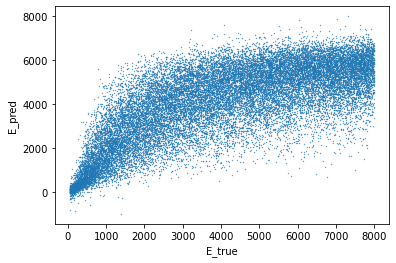

In [13]:
plt.scatter(y_val, y_pred, s=0.1)
plt.xlabel("E_true")
plt.ylabel("E_pred")
plt.show()

### Compute improvement

 Since our setup only includes a calorimeter, we assume that the resolution of a tracking measurement, performed independently by an upstream or downstream detector, scales linearly with energy, and equals 20% resolution at 1 TeV. We evaluate the resolution of both the regressor measurement and the simulated tracker measurement, along with the resolution of their weighted average. Resolution here is the fractional root median squared-error computed in bins of true energy according to:
            $$
                \text{Resolution} = \frac{\sqrt{\left(\tilde{E_p}-\tilde{E_t}\right)^2+\Delta_{68}\left[E_p\right]^2}}{\tilde{E_t}},
            $$
            where $\tilde{E_p}$ and $\tilde{E_t}$ are the median predicted and true energies in a given bin of true energy, and $\Delta_{68}\left[E_p\right]$ is the difference between the 16th and 84th percentiles of the predicted energy in that bin (the central 68th percentile width). When computing the resolution on the testing data (which are generated at fixed points of true energy), $\tilde{E_t}$ is instead the true energy at a given point. The metric is to compute the improvement of the combined measurement over the tracker-only measurement in bins of true energy, and take the average or sum; this then characterises the improvement due to the regression across the whole spectrum.

In [14]:
df = pd.DataFrame({'pred': y_pred, 'target': y_val})

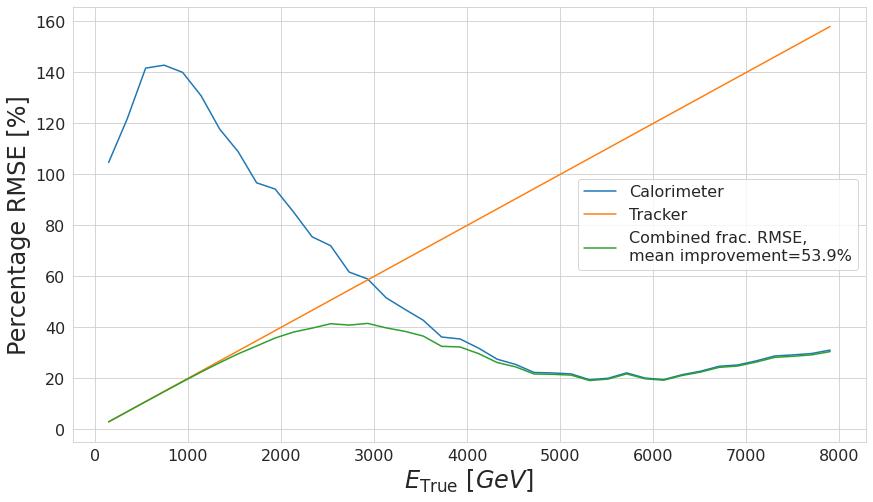

0.5389641848248535

In [15]:
compute_improvement(df)

## Create a submission

To create a submission for the challenge, predict the unlabelled 'muon_calo_test.hdf5' sample and save it to csv.

In [17]:
X_test, _ = get_hl('muon_calo_test.hdf5')

In [18]:
def create_submission(model, name="submission"):
    y_pred = model.predict(X_test)
    df = pd.DataFrame({'pred': y_pred})
    df.to_csv(name + ".csv")

In [19]:
create_submission(bdt)